In [248]:
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

In [249]:
coordinates_file = '../../Fieldwork/QGIS maps/SamplingSites.csv'
threshold = 185 # max distance is between HM-C and HM-D at ~ 180
threshold_times = 4

In [250]:
coord_df = pd.read_csv(coordinates_file)[['field_1','Easting','Northing']]
HM_coord_df = coord_df[coord_df['field_1'].str.contains("HM")]
HM_coord_array = HM_coord_df[['Easting','Northing']].to_numpy()
# HM_coord_array

In [251]:
HM_dist_matr = np.zeros((len(HM_coord_df),len(HM_coord_df)))
for i in range(len(HM_coord_df)):
    for j in range(len(HM_coord_df)):
        HM_dist_matr[i,j] = np.linalg.norm(HM_coord_array[i,:]-HM_coord_array[j,:])
pd.DataFrame(HM_dist_matr)

,0,1,2,3,4,5,6,7,8
0,0.000000,422.946460,316.191533,239.487669,171.843540,11.003556,154.497746,277.507299,397.120900
1,422.946460,0.000000,121.384265,221.261640,401.378646,429.621507,289.337223,209.127721,176.328978
2,316.191533,121.384265,0.000000,99.878320,279.997425,324.173050,205.709633,179.401727,220.435700
3,239.487669,221.261640,99.878320,0.000000,180.135097,248.999835,174.801352,212.110817,292.055969
4,171.843540,401.378646,279.997425,180.135097,0.000000,182.353455,241.623764,342.169288,447.779806
5,11.003556,429.621507,324.173050,248.999835,182.353455,0.000000,157.224327,279.893525,399.587674
6,154.497746,289.337223,205.709633,174.801352,241.623764,157.224327,0.000000,123.058499,242.624636
7,277.507299,209.127721,179.401727,212.110817,342.169288,279.893525,123.058499,0.000000,119.695520
8,397.120900,176.328978,220.435700,292.055969,447.779806,399.587674,242.624636,119.695520,0.000000


In [252]:
def get_neighb_matr(array,threshold,threshold_times):
    array[np.where(array>threshold)] = threshold_times * threshold
    return array

HM_neighb_matr = get_neighb_matr(HM_dist_matr,threshold,threshold_times)
pd.DataFrame(HM_neighb_matr)

,0,1,2,3,4,5,6,7,8
0,0.000000,740.000000,740.000000,740.000000,171.843540,11.003556,154.497746,740.000000,740.000000
1,740.000000,0.000000,121.384265,740.000000,740.000000,740.000000,740.000000,740.000000,176.328978
2,740.000000,121.384265,0.000000,99.878320,740.000000,740.000000,740.000000,179.401727,740.000000
3,740.000000,740.000000,99.878320,0.000000,180.135097,740.000000,174.801352,740.000000,740.000000
4,171.843540,740.000000,740.000000,180.135097,0.000000,182.353455,740.000000,740.000000,740.000000
5,11.003556,740.000000,740.000000,740.000000,182.353455,0.000000,157.224327,740.000000,740.000000
6,154.497746,740.000000,740.000000,174.801352,740.000000,157.224327,0.000000,123.058499,740.000000
7,740.000000,740.000000,179.401727,740.000000,740.000000,740.000000,123.058499,0.000000,119.695520
8,740.000000,176.328978,740.000000,740.000000,740.000000,740.000000,740.000000,119.695520,0.000000


In [253]:
from scipy.linalg import eigh

In [254]:
def PCoA(matrix,r=2):
    # https://lookmanolowo.web.illinois.edu/2024/03/13/principal-coordinate-analysis-hands-on/
    
    # square the matrix to emphasize the hidden structure within the dataset
    D = matrix.copy()
    D2 = np.pow(D,2)

    n = len(D)

    # get centering matrix A
    J = np.ones_like(D)
    I = np.diag(np.diag(J))
    A = I - (J / n)

    # get W, which encodes the variance and structure of the original dataset as represented by the squared distances, after being adjusted by double-centering
    W = -.5 * np.linalg.multi_dot([A, D2, A.T])
    
    # find the eigenvalues
    eigenvalues, eigenvectors = np.linalg.eigh(W)

    I = np.diag(np.diag(np.ones((r,r))))
    Λ_s = eigenvalues[:r] * I

    U_s = eigenvectors[:,:r]
    V_T = np.dot(U_s,Λ_s)

    return eigenvalues, eigenvectors, V_T

In [298]:
def skbio_pcoa(distance_matrix):

    # square the matrix to emphasize the hidden structure within the dataset
    D = distance_matrix.copy()
    D2 = np.pow(D,2)

    n = len(D)

    # get centering matrix A
    J = np.ones_like(D)
    I = np.diag(np.diag(J))
    A = I - (J / n)

    # get W, which encodes the variance and structure of the original dataset as represented by the squared distances, after being adjusted by double-centering
    W = -.5 * np.linalg.multi_dot([A, D2, A.T])

    eigvals, eigvecs = np.linalg.eigh(W)
    
    # Ensure number_of_dimensions does not exceed available dimensions
    # number_of_dimensions = min(number_of_dimensions, eigvals.shape[0])

    # cogent makes eigenvalues positive by taking the
    # abs value, but that doesn't seem to be an approach accepted
    # by L&L to deal with negative eigenvalues. We raise a warning
    # in that case. First, we make values close to 0 equal to 0.
    negative_close_to_zero = np.isclose(eigvals, 0)
    eigvals[negative_close_to_zero] = 0

    # eigvals might not be ordered, so we first sort them, then analogously
    # sort the eigenvectors by the ordering of the eigenvalues too
    idxs_descending = eigvals.argsort()[::-1]
    eigvals = eigvals[idxs_descending]
    eigvecs = eigvecs[:, idxs_descending]

    # If we return only the coordinates that make sense (i.e., that have a
    # corresponding positive eigenvalue), then Jackknifed Beta Diversity
    # won't work as it expects all the OrdinationResults to have the same
    # number of coordinates. In order to solve this issue, we return the
    # coordinates that have a negative eigenvalue as 0
    num_positive = (eigvals >= 0).sum()
    eigvecs[:, num_positive:] = np.zeros(eigvecs[:, num_positive:].shape)
    eigvals[num_positive:] = np.zeros(eigvals[num_positive:].shape)

    sum_eigenvalues = np.sum(eigvals)

    proportion_explained = eigvals / sum_eigenvalues
 
    # In case eigh is used, eigh computes all eigenvectors and -values.
    # So if number_of_dimensions was specified, we manually need to ensure
    # only the requested number of dimensions
    # (number of eigenvectors and eigenvalues, respectively) are returned.


    # Scale eigenvalues to have length = sqrt(eigenvalue). This
    # works because np.linalg.eigh returns normalized
    # eigenvectors. Each row contains the coordinates of the
    # objects in the space of principal coordinates. Note that at
    # least one eigenvalue is zero because only n-1 axes are
    # needed to represent n points in a euclidean space.
    coordinates = eigvecs * np.sqrt(eigvals)

    return eigvals,coordinates,proportion_explained

In [299]:
a = np.array([
[0,         4.551,  18.204,     8.306,  14.041],
[4.551,     0,      12.714,     3.918,  12.551],
[18.204,    12.714, 0,          8.633,  8.735],
[8.306,     3.918,  8.633,      0,      7.490],
[14.041,    12.551, 8.735,      7.490,  0]])

eigenvalues, eigenvectors, V_T = PCoA(a)

In [300]:
eigvals,coordinates,proportion_explained = skbio_pcoa(a)

In [301]:
coordinates

array([[-8.92725513,  1.49118279, -0.        ,  0.        ,  0.        ],
       [-4.55924243, -3.0239592 , -0.        ,  0.        ,  0.        ],
       [ 8.70772294, -3.05798329, -0.        ,  0.        ,  0.        ],
       [-0.1801753 , -0.65924254, -0.        ,  0.        ,  0.        ],
       [ 4.95894992,  5.25000224, -0.        ,  0.        ,  0.        ]])

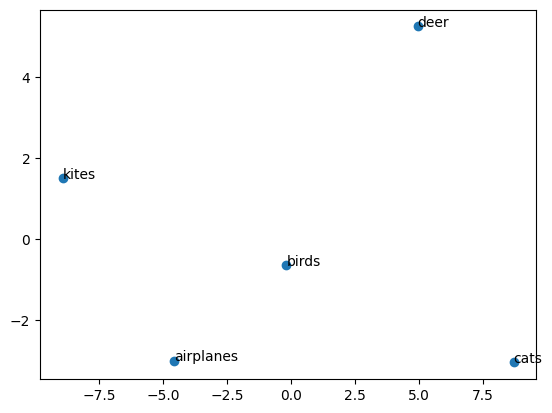

In [302]:
plt.scatter(coordinates[:,0],coordinates[:,1])
labels= ['kites','airplanes','cats','birds','deer']
for i in range(len(labels)):
    plt.text(coordinates[i,0],coordinates[i,1],labels[i])

In [260]:
pos_eigenvectors = eigenvectors.copy()
pos_eigenvectors[np.where(pos_eigenvectors<=0)] = 0
pos_eigenvalues = eigenvalues.copy()
pos_eigenvalues[np.where(pos_eigenvalues<=0)] = 0
pos_eigenvalues

array([  0.        ,   0.        ,   0.        ,  48.71634135,
       200.93066193])

In [261]:
eigenvalues

array([-1.32164506e+01, -4.49261892e+00, -7.99033800e-15,  4.87163413e+01,
        2.00930662e+02])

In [262]:
coordinates = pos_eigenvectors * np.sqrt(pos_eigenvalues)

In [263]:
coordinates

array([[0.        , 0.        , 0.        , 1.49118279, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 8.70772294],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 5.25000224, 4.95894992]])

In [264]:
labels= ['kites','airplanes','cats','birds','deer']

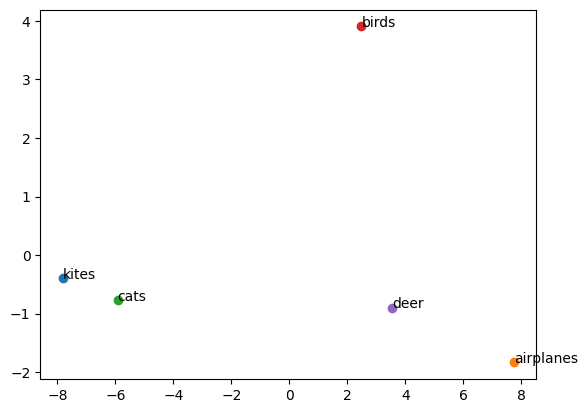

In [265]:
for i in range(len(labels)):
    plt.scatter(V_T[i,0],V_T[i,1])
    plt.text(V_T[i,0],V_T[i,1],labels[i])

In [266]:
V_T[:,0]

array([-7.8181138 ,  7.7315136 , -5.92765264,  2.48144826,  3.53280458])

In [267]:
from sklearn.manifold import MDS

In [268]:
# PCoA using MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
coordinates = mds.fit_transform(HM_neighb_matr)
# coordinates

In [269]:
# MDS(n_components=2, dissimilarity='precomputed').fit_transform(HM_neighb_matr)

In [270]:
# MDS(n_components=3, dissimilarity='precomputed').fit_transform(HM_neighb_matr)

In [271]:
labels = ['HM-PL','HM-PW-A','HM-PW-B','HM-PW-C','HM-PW-D','HM-PW-E','HM-PW-F','HM-PW-G','HM-PW-H',]

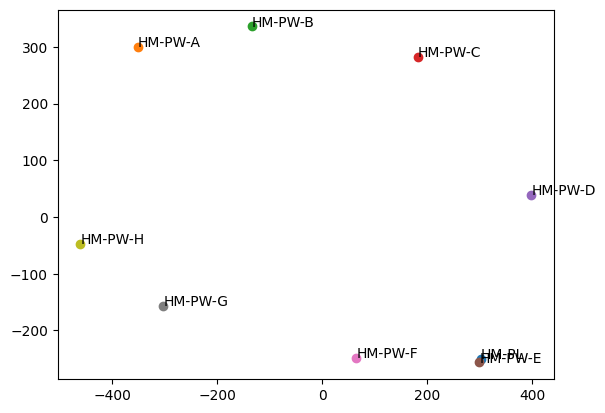

In [272]:
for i in range(len(labels)):
    plt.scatter(coordinates[i,0],coordinates[i,1])
    plt.text(coordinates[i,0],coordinates[i,1],labels[i])

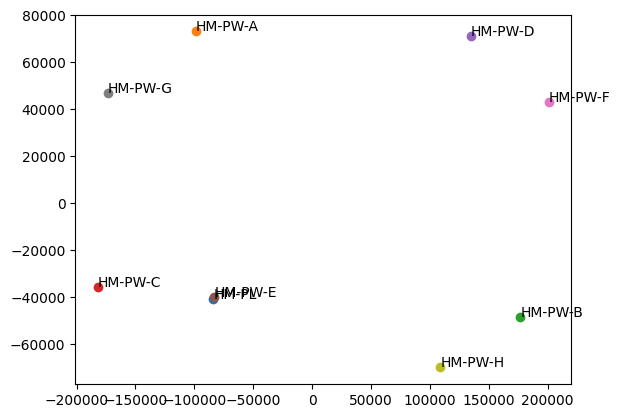

In [273]:
eigenvalues, eigenvectors, V_T = PCoA(HM_neighb_matr,r=9)
for i in range(len(labels)):
    plt.scatter(V_T[i,0],V_T[i,1])
    plt.text(V_T[i,0],V_T[i,1],labels[i])

In [274]:
matrix = np.array([
    [0,     3.1416,0.7854,1.5708],
    [3.1416,0,     2.3562,1.5708],
    [0.7854,2.3562,0,     2.3562],
    [1.5708,1.5708,2.3562,0     ],
])

# matrix = matrix = np.array([
#     [0, 1,  1,  1],
#     [1, 0,  1,  1],
#     [1, 1,  0,  1],
#     [1, 1,  1,  0],
# ])


pd.DataFrame(matrix)

,0,1,2,3
0,0.0000,3.1416,0.7854,1.5708
1,3.1416,0.0000,2.3562,1.5708
2,0.7854,2.3562,0.0000,2.3562
3,1.5708,1.5708,2.3562,0.0000


In [275]:
# https://lookmanolowo.web.illinois.edu/2024/03/13/principal-coordinate-analysis-hands-on/
r = 4
# square the matrix to emphasize the hidden structure within the dataset
D = matrix.copy()
D2 = np.pow(D,2)

n = len(D)

# get centering matrix A
J = np.ones_like(D)
I = np.diag(np.diag(J))
A = I - (J / n)

# get W, which encodes the variance and structure of the original dataset as represented by the squared distances, after being adjusted by double-centering
W = -.5 * np.linalg.multi_dot([A, D2, A.T])

# find the eigenvalues
eigenvalues, eigenvectors = eigh(W)

I = I[:r,:r]
Λ_s = eigenvalues[:r] * I

U_s = eigenvectors[:,:r]
V_T = np.dot(U_s,Λ_s)


In [276]:
pd.DataFrame(Λ_s)

,0,1,2,3
0,-1.203952,-0.000000e+00,0.00000,0.000000
1,-0.000000,-3.330669e-15,0.00000,0.000000
2,-0.000000,-0.000000e+00,2.22342,0.000000
3,-0.000000,-0.000000e+00,0.00000,5.611703


In [277]:
eigenvalues

array([-1.20395187e+00, -3.33066907e-15,  2.22342015e+00,  5.61170319e+00])

In [278]:
idx = eigenvalues > 0
eigenvalues[idx]

array([2.22342015, 5.61170319])

In [279]:
eigenvectors

array([[ 0.59304984,  0.5       , -0.26108863,  0.57456472],
       [ 0.39725483,  0.5       ,  0.30673769, -0.70576242],
       [-0.48712644,  0.5       ,  0.62397637,  0.3512283 ],
       [-0.50317822,  0.5       , -0.66962543, -0.2200306 ]])

In [280]:
new = eigenvectors[idx]
new

array([[-0.48712644,  0.5       ,  0.62397637,  0.3512283 ],
       [-0.50317822,  0.5       , -0.66962543, -0.2200306 ]])

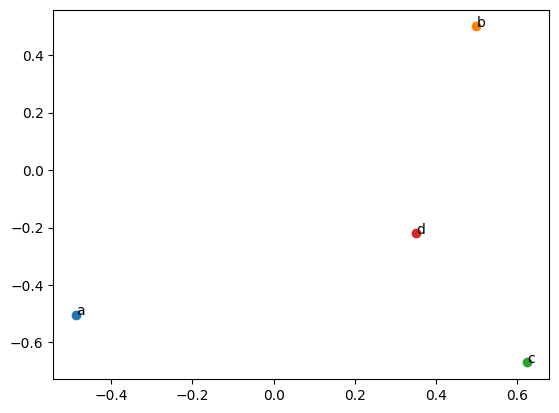

In [281]:
labels = ['a','b','c','d']

if len(new[:,0]) > 2:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    for i in range(len(new[0,:])):
        ax.scatter(new[0,i],new[1,i],new[2,i])
        ax.text(new[0,i],new[1,i],new[2,i],labels[i])

else:
    fig, ax = plt.subplots()

    for i in range(len(new[0,:])):
        ax.scatter(new[0,i],new[1,i],)
        ax.text(new[0,i],new[1,i],labels[i])

In [282]:
dist = np.zeros_like(matrix)

for i in range(len(labels)):
    for j in range(len(labels)):
        dist[i,j] = np.linalg.norm(new[:,i]-new[:,j])

In [283]:
dist

array([[0.        , 1.40740369, 1.12350084, 0.88487923],
       [1.40740369, 0.        , 1.17617761, 0.73523948],
       [1.12350084, 1.17617761, 0.        , 0.52585836],
       [0.88487923, 0.73523948, 0.52585836, 0.        ]])

In [284]:
new

array([[-0.48712644,  0.5       ,  0.62397637,  0.3512283 ],
       [-0.50317822,  0.5       , -0.66962543, -0.2200306 ]])

In [285]:
new[:,0]

array([-0.48712644, -0.50317822])

In [286]:
new[:,0]

array([-0.48712644, -0.50317822])

In [287]:
# Pairwise distance between European cities
url = 'https://media.githubusercontent.com/media/neurospin/pystatsml/refs/heads/master/datasets/eurodist.csv'
df = pd.read_csv(url)
print(df)
print()
## Array with cities:
city = np.array(df["city"])

## Squareform distance matrix
D = np.array(df)[:,1:]
print(D.shape)
print()
print(city)

               city  Athens  Barcelona  Brussels  Calais  Cherbourg  Cologne  \
0            Athens       0       3313      2963    3175       3339     2762   
1         Barcelona    3313          0      1318    1326       1294     1498   
2          Brussels    2963       1318         0     204        583      206   
3            Calais    3175       1326       204       0        460      409   
4         Cherbourg    3339       1294       583     460          0      785   
5           Cologne    2762       1498       206     409        785        0   
6        Copenhagen    3276       2218       966    1136       1545      760   
7            Geneva    2610        803       677     747        853     1662   
8         Gibraltar    4485       1172      2256    2224       2047     2436   
9           Hamburg    2977       2018       597     714       1115      460   
10  Hook of Holland    3030       1490       172     330        731      269   
11           Lisbon    4532       1305  

In [288]:
D.shape

(21, 21)

In [289]:
city[1]

'Barcelona'

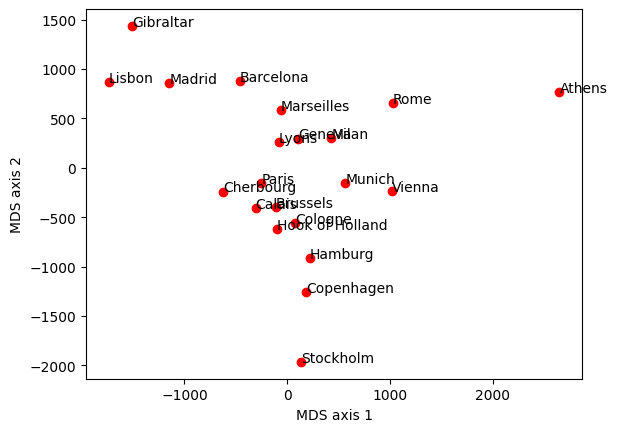

In [290]:
mds_2d = MDS(n_components=2, dissimilarity='precomputed').fit_transform(D)


plt.scatter(mds_2d[:,0], mds_2d[:,1], color='red')
for i in range(len(city)):
    plt.text(mds_2d[i,0], mds_2d[i,1], city[i])

plt.xlabel('MDS axis 1')
plt.ylabel('MDS axis 2')
plt.show()

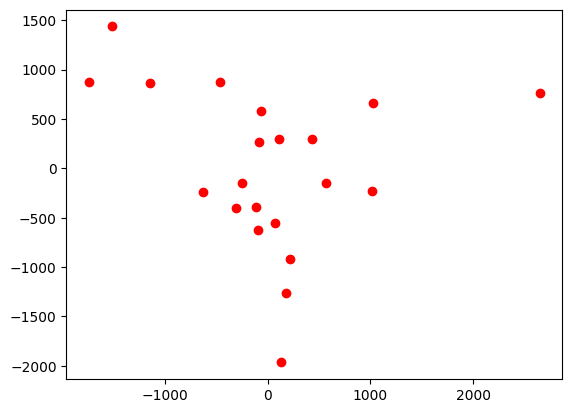

In [291]:

plt.scatter(mds_2d[:,0], mds_2d[:,1], color='red')

In [292]:
from scipy.linalg import eigh

In [293]:
pd.DataFrame(D)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0,3313,2963,3175,3339,2762,3276,2610,4485,2977,...,4532,2753,3949,2865,2282,2179,3000,817,3927,1991
1,3313,0,1318,1326,1294,1498,2218,803,1172,2018,...,1305,645,636,521,1014,1365,1033,1460,2868,1802
2,2963,1318,0,204,583,206,966,677,2256,597,...,2084,690,1558,1011,925,747,285,1511,1616,1175
3,3175,1326,204,0,460,409,1136,747,2224,714,...,2052,739,1550,1059,1077,977,280,1662,1786,1381
4,3339,1294,583,460,0,785,1545,853,2047,1115,...,1827,789,1347,1101,1209,1160,340,1794,2196,1588
5,2762,1498,206,409,785,0,760,1662,2436,460,...,2290,714,1764,1035,911,583,465,1497,1403,937
6,3276,2218,966,1136,1545,760,0,1418,3196,460,...,2971,1458,2498,1778,1537,1104,1176,2050,650,1455
7,2610,803,677,747,853,1662,1418,0,1975,1118,...,1936,158,1439,425,328,591,513,995,2068,1019
8,4485,1172,2256,2224,2047,2436,3196,1975,0,2897,...,676,1817,698,1693,2185,2565,1971,2631,3886,2974
9,2977,2018,597,714,1115,460,460,1118,2897,0,...,2671,1159,2198,1479,1238,805,877,1751,949,1155


In [ ]:
def skbio_pcoa(distance_matrix):

    # square the matrix to emphasize the hidden structure within the dataset
    D = distance_matrix.copy()
    D2 = np.pow(D,2)

    n = len(D)

    # get centering matrix A
    J = np.ones_like(D)
    I = np.diag(np.diag(J))
    A = I - (J / n)

    # get W, which encodes the variance and structure of the original dataset as represented by the squared distances, after being adjusted by double-centering
    W = -.5 * np.linalg.multi_dot([A, D2, A.T])

    eigvals, eigvecs = np.linalg.eigh(W)
    
    # Ensure number_of_dimensions does not exceed available dimensions
    # number_of_dimensions = min(number_of_dimensions, eigvals.shape[0])

    # cogent makes eigenvalues positive by taking the
    # abs value, but that doesn't seem to be an approach accepted
    # by L&L to deal with negative eigenvalues. We raise a warning
    # in that case. First, we make values close to 0 equal to 0.
    negative_close_to_zero = np.isclose(eigvals, 0)
    eigvals[negative_close_to_zero] = 0

    # eigvals might not be ordered, so we first sort them, then analogously
    # sort the eigenvectors by the ordering of the eigenvalues too
    idxs_descending = eigvals.argsort()[::-1]
    eigvals = eigvals[idxs_descending]
    eigvecs = eigvecs[:, idxs_descending]

    # If we return only the coordinates that make sense (i.e., that have a
    # corresponding positive eigenvalue), then Jackknifed Beta Diversity
    # won't work as it expects all the OrdinationResults to have the same
    # number of coordinates. In order to solve this issue, we return the
    # coordinates that have a negative eigenvalue as 0
    num_positive = (eigvals >= 0).sum()
    eigvecs[:, num_positive:] = np.zeros(eigvecs[:, num_positive:].shape)
    eigvals[num_positive:] = np.zeros(eigvals[num_positive:].shape)

    sum_eigenvalues = np.sum(eigvals)

    proportion_explained = eigvals / sum_eigenvalues
 
    # In case eigh is used, eigh computes all eigenvectors and -values.
    # So if number_of_dimensions was specified, we manually need to ensure
    # only the requested number of dimensions
    # (number of eigenvectors and eigenvalues, respectively) are returned.


    # Scale eigenvalues to have length = sqrt(eigenvalue). This
    # works because np.linalg.eigh returns normalized
    # eigenvectors. Each row contains the coordinates of the
    # objects in the space of principal coordinates. Note that at
    # least one eigenvalue is zero because only n-1 axes are
    # needed to represent n points in a euclidean space.
    coordinates = eigvecs * np.sqrt(eigvals)

    return eigvals,coordinates,proportion_explained

In [295]:
eigvals,coordinates,proportion_explained = skbio_pcoa(D.astype(float))

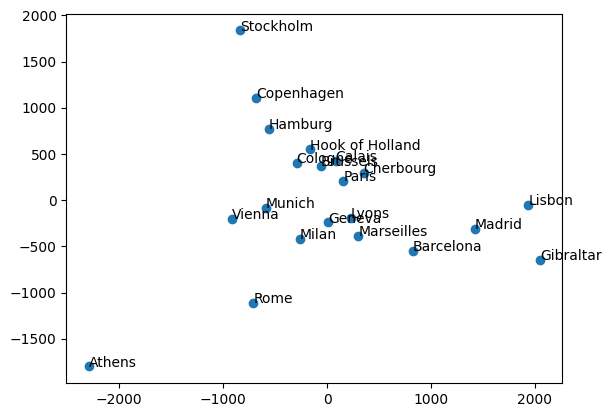

In [296]:
plt.scatter(coordinates[:,0],coordinates[:,1])
for i in range(len(city)):
    plt.text(coordinates[i,0], coordinates[i,1], city[i])